# Trouble-Shooting

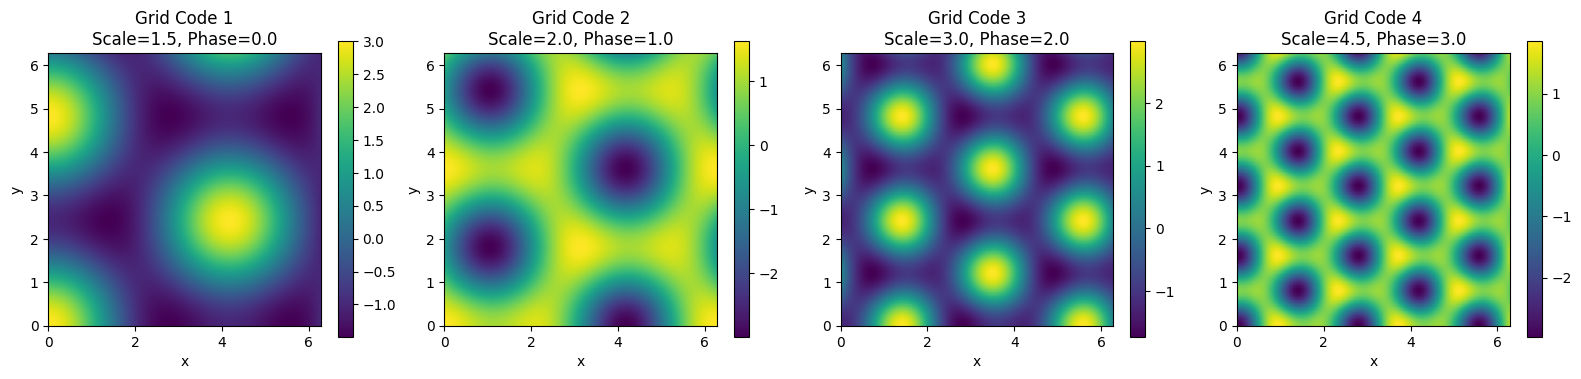

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# Only for visualization
def grid_cell_field(x, y, scales, phases):
    directions = np.array([
        [1, 0],
        [-0.5,  np.sqrt(3)/2],
        [-0.5, -np.sqrt(3)/2]
    ])

    r = np.stack([x, y], axis=-1)  # shape (..., 2)
    features = []

    for scale, phase in zip(scales, phases):
        value = np.zeros_like(x)
        for k in directions:
            k_scaled = scale * k
            dot = x * k_scaled[0] + y * k_scaled[1]
            value += np.cos(dot + phase)
        features.append(value)

    return np.array(features)  # shape: (len(scales), H, W)

# Set up space
x_vals = np.linspace(0, 2*np.pi, 200)
y_vals = np.linspace(0, 2*np.pi, 200)
X, Y = np.meshgrid(x_vals, y_vals)

# Define grid cell parameters
scales = [1.5, 2.0, 3.0, 4.5]
phases = [0.0, 1.0, 2.0, 3.0]

# Evaluate grid cell population code
Zs = grid_cell_field(X, Y, scales, phases)  # shape (4, H, W)

# Plot each feature
fig, axs = plt.subplots(1, len(scales), figsize=(16, 4))
for i in range(len(scales)):
    ax = axs[i]
    im = ax.imshow(Zs[i], extent=[0, 2*np.pi, 0, 2*np.pi], origin='lower', cmap='viridis')
    ax.set_title(f"Grid Code {i+1}\nScale={scales[i]}, Phase={phases[i]}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()


In [384]:
import numpy as np
# simulates 4 grid cells
# each defined by a unique spatial scale
# a unique phase offset
# each value of s, the output of grid cell, tells you how aligned the position (x,y) is
# with the preferred firing field of a specific grid cell
def grid_cell(x,y,scales,phases):
    directions=np.array([
        [1,0],
        [-0.5,np.sqrt(3)/2],
        [-0.5, -np.sqrt(3)/2]
    ])

    r = np.array([x,y])
    features = []

    for scale,phase in zip(scales,phases):
        value=0.0
        for k in directions:
            dot = np.dot(scale * k, r)
            value += np.cos(dot + phase)
        features.append(value)

    features = np.array(features).reshape(-1,1)
    return features

scales = [1.5, 2.0, 3.0, 4.5]  # different spatial frequencies
phases = [0.0, 1.0, 2.0, 3.0]  # different phase offsets

# assumes no interaction between features
def concatenated_feature_vector(s, u):
    u_col = np.array([[u]])
    return np.vstack([s, u_col])

s = grid_cell(x=0.2, y=1., scales=scales, phases=phases)
u = np.pi/2
psi = concatenated_feature_vector(s,u)

# assumes interaction between features
import numpy as np

def outer_product_feature_vector(s, u):
    # relu function
    direction_vec = np.array([np.maximum(np.cos(u),0),
                              np.maximum(-np.cos(u),0),
                              np.maximum(np.sin(u),0),
                              np.maximum(-np.sin(u),0)])[:,None]
    psi = s @ direction_vec.T             # (mx1) x(1x4) --> (mx4) 
    return psi.flatten().reshape(-1, 1) # (4mx1)

s = grid_cell(x=0.2, y=1.0, scales=scales, phases=phases)  # s: (4×1)
u = np.pi / 2  # Direction = 90 degrees
psi = outer_product_feature_vector(s, u)  # psi: (8×1)

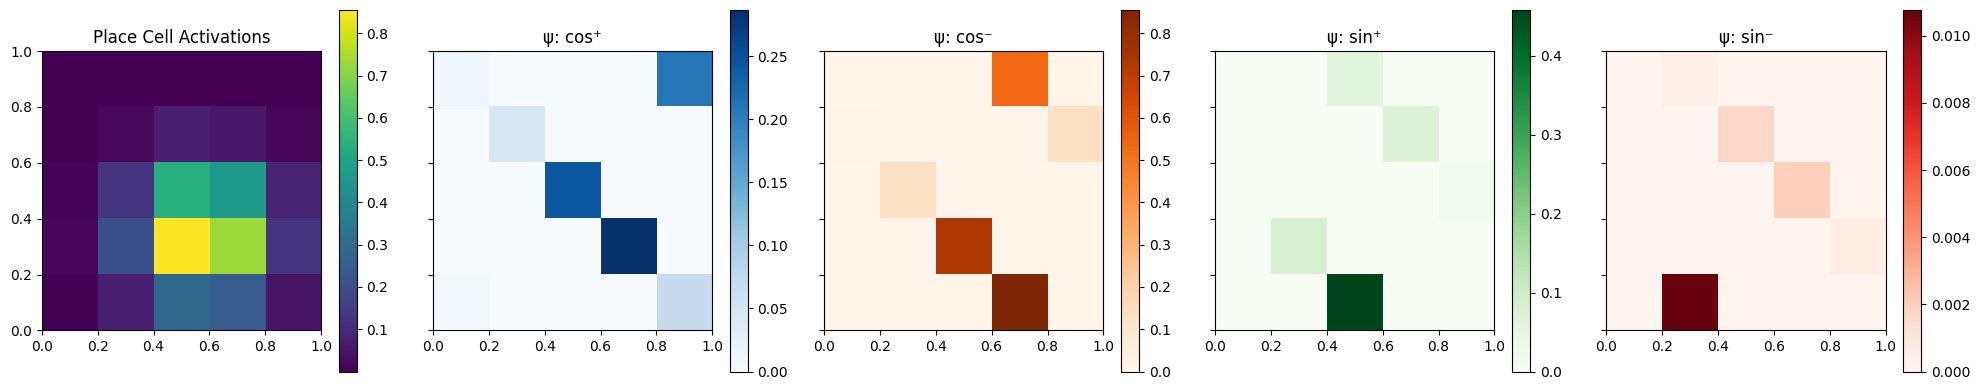

In [393]:
import numpy as np
import matplotlib.pyplot as plt

def place_cells(x, y, centers, sigma=0.1):
    r = np.array([x, y])
    features = []
    for c in centers:
        dist_sq = np.sum((r - np.array(c)) ** 2)
        activation = np.exp(-dist_sq / (2 * sigma ** 2))
        features.append(activation)
    return np.array(features).reshape(-1, 1)

def outer_product_feature_vector(s, u):
    # relu function
    direction_vec = np.array([np.maximum(np.cos(u),0),
                              np.maximum(-np.cos(u),0),
                              np.maximum(np.sin(u),0),
                              np.maximum(-np.sin(u),0)])[:,None]
    psi = s @ direction_vec.T             # (mx1) x(1x4) --> (mx4) 
    return psi.flatten().reshape(-1, 1) # (4mx1)

# Grid setup
n = 5
grid_x, grid_y = np.linspace(0, 1, n), np.linspace(0, 1, n)
centers = [(x, y) for x in grid_x for y in grid_y]

# Agent position and heading
x, y = 0.3, 0.6
u =  0 # 45 degrees

# Compute activations and features
s = place_cells(x, y, centers, sigma=0.2)
psi = outer_product_feature_vector(s, u)

# Prepare visualizations
place_activations = s.reshape(n, n)
m = len(s)  # number of place cells (should be 25)
psi_cos_pos = psi[0*m : 1*m].reshape(n, n)
psi_cos_neg = psi[1*m : 2*m].reshape(n, n)
psi_sin_pos = psi[2*m : 3*m].reshape(n, n)
psi_sin_neg = psi[3*m : 4*m].reshape(n, n)
fig, axs = plt.subplots(1, 5, figsize=(20, 4), sharey=True)

# Place field
im0 = axs[0].imshow(place_activations, origin='lower', cmap='viridis', extent=[0, 1, 0, 1])
axs[0].set_title("Place Cell Activations")
fig.colorbar(im0, ax=axs[0])

# Cos⁺
im1 = axs[1].imshow(psi_cos_pos, origin='lower', cmap='Blues', extent=[0, 1, 0, 1])
axs[1].set_title("ψ: cos⁺")
fig.colorbar(im1, ax=axs[1])

# Cos⁻
im2 = axs[2].imshow(psi_cos_neg, origin='lower', cmap='Oranges', extent=[0, 1, 0, 1])
axs[2].set_title("ψ: cos⁻")
fig.colorbar(im2, ax=axs[2])

# Sin⁺
im3 = axs[3].imshow(psi_sin_pos, origin='lower', cmap='Greens', extent=[0, 1, 0, 1])
axs[3].set_title("ψ: sin⁺")
fig.colorbar(im3, ax=axs[3])

# Sin⁻
im4 = axs[4].imshow(psi_sin_neg, origin='lower', cmap='Reds', extent=[0, 1, 0, 1])
axs[4].set_title("ψ: sin⁻")
fig.colorbar(im4, ax=axs[4])

plt.tight_layout()
plt.show()

In [394]:
theta = np.random.randn(psi.shape[0]).reshape(1,-1) # row vector
output = theta @ psi # theta corresponds to different synapses, psi corresponds to some presyanptic neuron
# multiplication of theta and psi corresponds to some post-synaptic output
# would just be sensory information + action
# does not include predictions + sensory information + action where predictions should function as a prior

In [195]:
def eligibility_vector_update(e_t, psi_t, P_t = None, delta_t=0.1, e_max = 1.0, beta=0.5):
    assert e_t.shape == psi_t.shape, "Shape mismatch"
    if P_t is not None:
        delta_e_t = beta * -e_t + psi_t * (e_max - e_t) * P_t # Should we include the instructive signal in this?
    else:
        delta_e_t = beta * -e_t + psi_t * (e_max - e_t)
    e_t = e_t + delta_t * delta_e_t # Euler's method with step size delta t
    return np.clip(e_t, 0.0, None)

e_t = np.random.randn(5,1)
psi_t = np.random.randn(5, 1)
eligibility_vector_update(e_t, psi_t)

# # Simulate decay after a pulse of input
# T = 200  # extended time
# pulse_duration = 50
# delta_t = 0.08
# d=5
# psi_t = np.zeros((T, d))

# # Provide a constant pulse for some duration, then set to 0
# psi_t[:pulse_duration] = 1.0

# # No instructive signal (pure decay and buildup)
# e_trace = np.zeros((T, d))
# e_t = np.zeros((d, 1))

# for t in range(T):
#     e_t = eligibility_vector_update(e_t, psi_t[t].reshape(d, 1), P_t=None, delta_t=delta_t)
#     e_trace[t] = e_t.flatten()

# # Plotting
# plt.figure(figsize=(8, 5))
# plt.plot(np.arange(T) * delta_t, e_trace, label="Eligibility Trace e(t)")
# plt.axvline(x=pulse_duration * delta_t, color='gray', linestyle='--', label='Input Pulse Ends')
# plt.xlabel("Time (s)")
# plt.ylabel("Eligibility Trace e(t)")
# plt.title("Eligibility Trace with Input Pulse and Post-Pulse Decay")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

array([[0.04311012],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.09130549]])

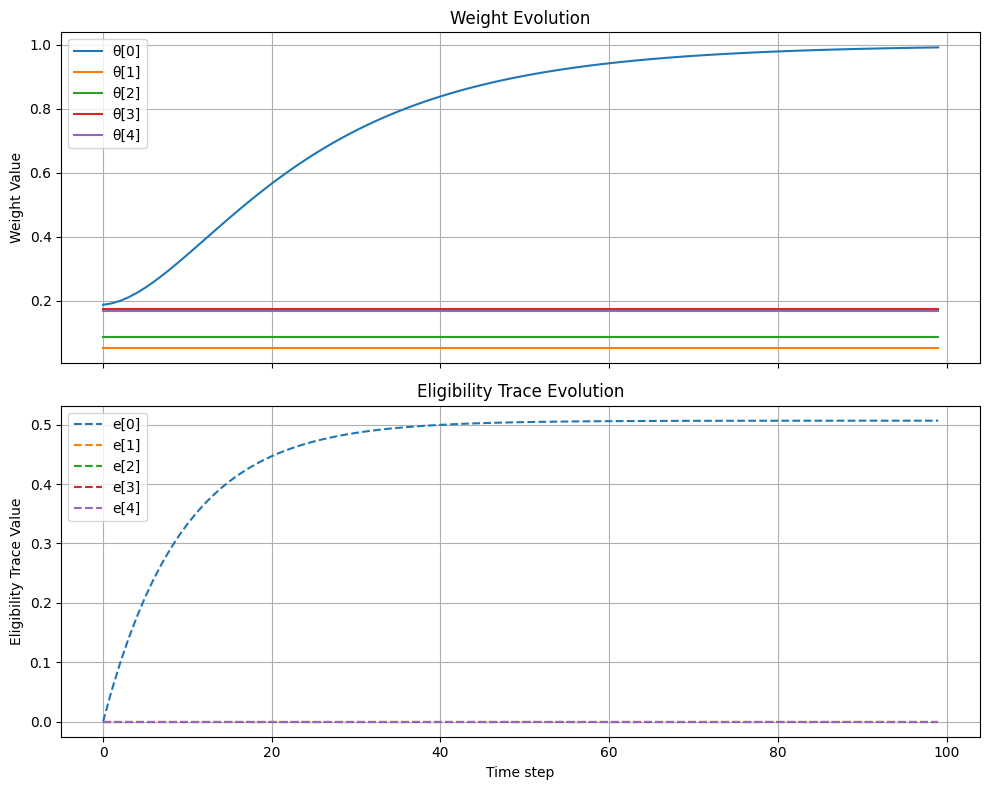

In [406]:
import numpy as np
import matplotlib.pyplot as plt

# Weight update function
def weight_update(theta_t, delta_t, e_t):
    theta_t_plus_1 = theta_t + delta_t * (1 - theta_t) * e_t
    return np.clip(theta_t_plus_1, 0.0, None) # Clip to minimum 0

# Parameters
T = 100  # time steps
d = 5    # feature dimensions
delta_t = 0.1

# Initialize
theta_trace = np.zeros((T, d))
eligibility_trace = np.zeros((T, d))

theta_t = np.random.uniform(low=0.0, high=0.2, size=(d, 1))  # column vector
e_t = np.zeros((d, 1))
psi_t = np.random.randn(d, 1)
P_t = 1.0

theta_trace[0] = theta_t.flatten()
eligibility_trace[0] = e_t.flatten()

for t in range(1, T):
    e_t = eligibility_vector_update(e_t, psi_t, P_t, delta_t=delta_t)
    theta_t = weight_update(theta_t, delta_t, e_t)
    eligibility_trace[t] = e_t.flatten()
    theta_trace[t] = theta_t.flatten()

# Plot results
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Weights
for i in range(d):
    axs[0].plot(np.arange(T), theta_trace[:, i], label=f'θ[{i}]')
axs[0].set_ylabel("Weight Value")
axs[0].set_title("Weight Evolution")
axs[0].legend()
axs[0].grid(True)

# Eligibility
for i in range(d):
    axs[1].plot(np.arange(T), eligibility_trace[:, i], label=f'e[{i}]', linestyle='--')
axs[1].set_xlabel("Time step")
axs[1].set_ylabel("Eligibility Trace Value")
axs[1].set_title("Eligibility Trace Evolution")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Putting it all together

In [518]:
def place_cells(x, y, centers, sigma=0.1):
    centers = np.asarray(centers, dtype=float) # shape (N,2)
    r = np.array([x,y], dtype=float) # shape (2,)
    # vectorized distance:
    diff = centers - r[np.newaxis, :]
    dist_sq = np.sum(diff**2, axis=1) # shape (N,)

    activations = np.exp(-dist_sq / (2 * sigma**2))
    return activations.reshape(-1,1) # shape (N,1)

n_x, n_y = 5, 4
grid_x = np.linspace(0, 1, n_x)
grid_y = np.linspace(0, 1, n_y)
centers = [(x, y) for x in grid_x for y in grid_y]
num_place_cells = len(centers)   # 5 * 4 = 20

s = place_cells(0.1,0.1, centers)

def outer_product_feature_vector(s, u):
    # ensure s is (m,1)
    s = np.asarray(s)
    assert s.ndim==2 and s.shape[1] == 1, f"s must be (m,1), got {s.shape}"

    c, s_ = np.cos(u), np.sin(u)
    # relu function
    direction_vec = np.array([
        max(c, 0),
        max(-c, 0),
        max(s_, 0),
        max(-s_, 0)
    ]).reshape(4, 1)

    # (m,1) @ (1,4) --> (m,4)
    psi = s @ direction_vec.T            
    return psi.reshape(-1, 1) # (4mx1)

psi = outer_product_feature_vector(s, np.pi)
s.shape

(20, 1)

In [38]:
import numpy as np
import matplotlib.pyplot as plt

class GridEnvironment:
    def __init__(
            self, 
            place_centers, 
            grid_size=(1, 1), 
            step_length = 0.1, 
            start=None, 
            wrap=False, 
            distance_from_border=0.1, 
            reward_location=(0.5, 0.5), 
            tau_I=0.5, 
            gamma=1.0,
            snap_to_centers=True):
        self.grid_size = grid_size
        self.wrap = wrap  # if True, agent wraps around edges like Pac-Man
        self.step_length = step_length
        self.db = distance_from_border
        self.reward_location=np.array(reward_location)
        self.tau_I=tau_I
        self.gamma = gamma
        self.snap_to_centers = snap_to_centers
        self.place_centers = np.asarray(place_centers, float)
        assert self.place_centers.ndim == 2 and self.place_centers.shape[1] == 2, \
        "place_centers must be an iterable of (x,y) pairs"

        # Random or fixed start position
        if start is None:
            self.position = self._sample_random_position()
        else:
            self.position = np.array(start)
        self.trajectory = [self.position.copy()]
        self.prev_distance = np.linalg.norm(self.position - self.reward_location)


    def _sample_random_position(self):
        x = np.random.uniform(self.db, self.grid_size[0] - self.db)
        y = np.random.uniform(self.db, self.grid_size[1] - self.db)
        return np.array([x,y])

    def reset(self, start=None):
        if start is None:
            self.position = self._sample_random_position()
        else:
            start = np.array(start, dtype=float)
            assert 0 <= start[0] <= self.grid_size[0] and 0 <= start[1] <= self.grid_size[1], (
                f"start={start} out of bounds {self.grid_size}"
            )
            self.position=start
            
        self.trajectory = [self.position.copy()]
        self.prev_distance = np.linalg.norm(self.position - self.reward_location)

    def move(self, theta):
        """
        Move in the direction given by theta, clipped to grid boundaries.
        """

        place_centers = self.place_centers
        step = self.step_length * np.array([np.cos(theta), np.sin(theta)])
        tentative_position = self.position + step

        # Clip to grid bounds
        tentative_position = np.clip(tentative_position, [0, 0], np.array(self.grid_size) - 1e-5)

        if self.snap_to_centers:
            # snap to nearest place center
            dists = np.linalg.norm(place_centers - tentative_position, axis=1)
            nearest_idx = np.argmin(dists)
            self.position = np.array(place_centers[nearest_idx])
        else:
            # free movement
            self.position = tentative_position

        self.trajectory.append(self.position.copy())

    def compute_I(self):
        """
        computation of instructive signal
        I_t = γ · sign(d_{t−1} − d_t) · exp(−d_t² / 2τ_I²)
        """
        assert self.tau_I > 0, f"tau_I must be >0, got {self.tau_I}"
        curr_distance = np.linalg.norm(self.position - self.reward_location)
        delta_d = self.prev_distance - curr_distance
        sign_term = np.sign(delta_d)
        sign_term = 1.0 if delta_d > 0 else 0.0
        gaussian_term = np.exp(-curr_distance**2 / (2 * self.tau_I**2))
        I_t = self.gamma * sign_term * gaussian_term
        self.prev_distance = curr_distance
        return float(I_t)

    def get_position(self):
        return tuple(self.position)

    def __repr__(self):
        return f"Agent position: {tuple(self.position)}"
    
    def plot_trajectory(self, I_values=None):
        traj = np.array(self.trajectory)

        fig, ax = plt.subplots(figsize=(6, 6))
        
        # Color-code by sign of I_t
        if I_values is not None:
            colors = ['green' if I > 0 else 'red' if I < 0 else 'gray' for I in I_values]
            for i in range(len(traj)-1):
                ax.plot(traj[i:i+2, 0], traj[i:i+2, 1], '-', color=colors[i], linewidth=2)
                ax.scatter(traj[i+1, 0], traj[i+1, 1], c=colors[i], s=60)
                ax.text(traj[i+1, 0] + 0.01, traj[i+1, 1] + 0.01, f"{I_values[i]:.2f}", fontsize=12)
        else:
            ax.plot(traj[:, 0], traj[:, 1], '-o', color='blue')

        # Start and end
        ax.scatter(traj[0, 0], traj[0, 1], c='black', s=100, label='Start')
        ax.scatter(traj[-1, 0], traj[-1, 1], c='purple', s=100, label='End')
        ax.scatter(self.reward_location[0], self.reward_location[1],
           c='gold', s=100, marker='*', label='Reward')


        ax.set_xlim(0, self.grid_size[0])
        ax.set_ylim(0, self.grid_size[1])
        ax.set_aspect('equal')
        ax.set_title("Agent Trajectory with Instructive Signal")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        plt.show()

def place_cells(x, y, centers, sigma=0.1):
    centers = np.asarray(centers, dtype=float) # shape (N,2)
    r = np.array([x,y], dtype=float) # shape (2,)
    # vectorized distance:
    diff = centers - r[np.newaxis, :]
    dist_sq = np.sum(diff**2, axis=1) # shape (N,)

    activations = np.exp(-dist_sq / (2 * sigma**2))
    return activations.reshape(-1,1) # shape (N,1)

def outer_product_feature_vector(s, u):
    # ensure s is (m,1)
    s = np.asarray(s)
    assert s.ndim==2 and s.shape[1] == 1, f"s must be (m,1), got {s.shape}"

    c, s_ = np.cos(u), np.sin(u)
    # relu function
    direction_vec = np.array([
        max(c, 0),
        max(-c, 0),
        max(s_, 0),
        max(-s_, 0)
    ]).reshape(4, 1)

    # (m,1) @ (1,4) --> (m,4)
    psi = s @ direction_vec.T            
    return psi.reshape(-1, 1) # (4mx1)

def eligibility_vector_update(e_t, psi_t, P_t = None, delta_t=0.1, e_max = 1.0, beta=0.5):
    assert e_t.shape == psi_t.shape, f"e_t {e_t.shape} vs psi_t {psi_t.shape}"

    # 2) compute derivative
    if P_t is not None:
        delta_e = -beta * e_t + psi_t * (e_max - e_t) * P_t # Should we include the instructive signal in this?
    else:
        delta_e = -beta * e_t + psi_t * (e_max - e_t)

    # 3) euler update
    e_next = e_t + delta_t * delta_e # Euler's method with step size delta t
    return np.clip(e_next, 0.0, None)

# Weight update function
def weight_update(theta_t, P_t, e_t, update_log=None, 
                  trial_idx=None, step_idx=None, theta_max = None, log_threshold=1e-6):
    # 1) shape checks
    assert theta_t.shape == e_t.shape, f"θ and e must match shapes: {theta_t.shape} vs {e_t.shape}"
    if np.ndim(P_t) > 0:
        assert P_t.shape == theta_t.shape, f"P_t must be scalar or same shape as θ: got {P_t.shape}"

    # 2) compute update
    delta_theta = P_t * (1 - theta_t) * e_t
    theta_tp1 = theta_t + delta_theta

    # 3) clipping: lower bound 0, optional upper bound
    lower, upper = 0.0, theta_max if theta_max is not None else None
    theta_tp1 = np.clip(theta_tp1, lower, upper)

    # 4) logging
    if update_log is not None and trial_idx is not None and step_idx is not None:
        # find weight‐indices where |Δθ| > threshold
        changed = np.where(np.abs(delta_theta) > log_threshold)[0]
        for idx in changed:
            update_log.append((trial_idx, step_idx, idx, float(delta_theta[idx])))

    return theta_tp1

def value_function_approximation(theta, psi):
    # ensure same size
    assert theta.shape == psi.shape, f"Shape mismatch: {theta.shape} vs {psi.shape}"
    value = theta.T @ psi # theta corresponds to different synapses, psi corresponds to some presyanptic neuron
    return value

def select_action(s, theta, actions, temperature=0.2):
    q_values=[]
    for u in actions:
        psi = outer_product_feature_vector(s,u)
        q = float(value_function_approximation(theta,psi))
        q_values.append(q)
    q_values=np.array(q_values)

    logits = q_values/temperature
    logits -= np.max(logits)
    probs = np.exp(logits)
    probs /= np.sum(probs)

    # sample an action
    action = np.random.choice(actions, p=probs)
    return action

n_x, n_y = 10, 10
grid_x = np.linspace(0, 1, n_x)
grid_y = np.linspace(0, 1, n_y)
centers = [(x, y) for x in grid_x for y in grid_y]
num_place_cells = len(centers)   # 5 * 4 = 20
actions = np.linspace(0, 2 * np.pi, 4, endpoint=False)
theta = np.random.uniform(low=0.0, high=0.001, size=(num_place_cells*4,1))

num_trials = 3000
steps_per_trial = 10
delta_t = 0.1
beta=0.3
temperature=0.5
tau_I=0.5
snap_to_centers=False
all_I_values = []

env = GridEnvironment(grid_size=(1, 1), place_centers=centers, tau_I=tau_I)
weight_history = [theta.copy()]
all_trajectories = []
update_log = []

for trial in range(num_trials):
    env.reset()
    e_t = np.zeros_like(theta)  # Reset eligibility trace
    I_values = []

    for t in range(steps_per_trial):
        # what is the current position?
        x, y = env.get_position() 
        # feature vector of current position
        s = place_cells(x, y, centers) 
        # how should I act given the current position and my weight vector?
        a = select_action(s, theta, actions, temperature=temperature) 
        # I act
        env.move(a)
        # given the action that I chose, what is the feature vector?
        psi = outer_product_feature_vector(s, a)
        # I compute the instructive signal on the basis of where I moved
        P_t = env.compute_I()
        # Let's use this to update the eligibility vector
        e_t = eligibility_vector_update(e_t, psi, P_t, beta=beta, delta_t=delta_t)
        # If the action was a good one I get an instructive signal,
        # If it was not a good one, I don't get an instructive signal
        # I update my weights; if the action was a good one, the weights for the actions
        # that contributed to a good outcome will be increased, becoming more likely the next time
        theta = weight_update(theta, P_t, e_t, update_log=update_log, trial_idx=trial, step_idx=t)
        weight_history.append(theta.copy())
        I_values.append(P_t)
    
    all_trajectories.append(np.array(env.trajectory))
    all_I_values.append(I_values)

results = {
    "trajectories": all_trajectories,
    "instructive_signals": all_I_values,
    "weight_history": weight_history,
    "update_log": update_log,
}

C:\Users\nicho\AppData\Local\Temp\ipykernel_26660\2050553189.py:209: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q = float(value_function_approximation(theta,psi))
C:\Users\nicho\AppData\Local\Temp\ipykernel_26660\2050553189.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  update_log.append((trial_idx, step_idx, idx, float(delta_theta[idx])))


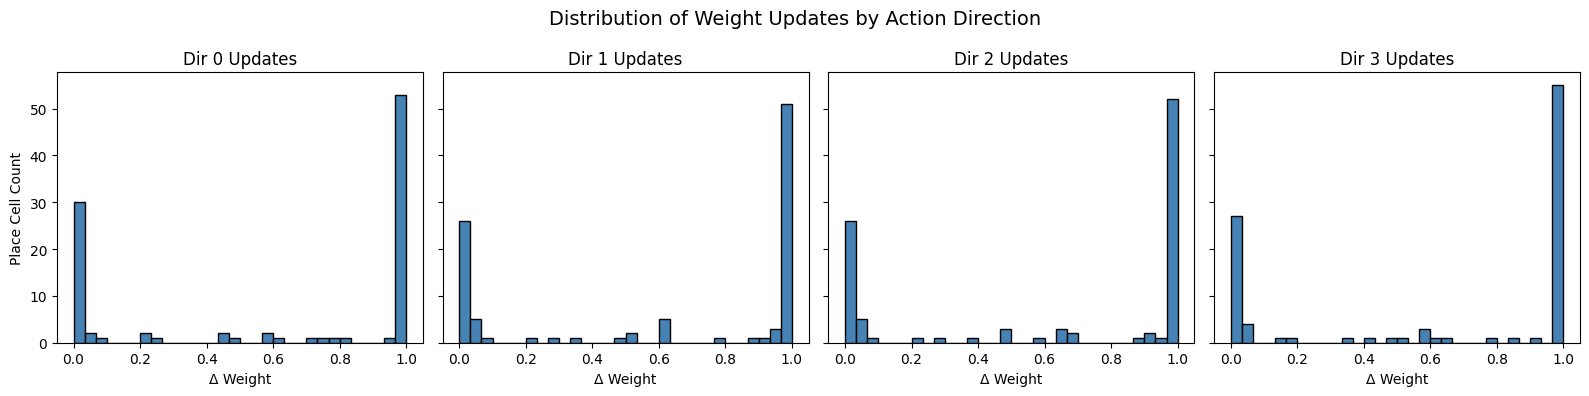

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def plot_weight_update_histograms(update_log, num_place_cells, num_directions=4):
    update_array = np.zeros((num_place_cells, num_directions))

    for _, _, idx, delta in update_log:
        cell_idx = idx // num_directions
        dir_idx = idx % num_directions
        update_array[cell_idx, dir_idx] += abs(delta)

    fig, axes = plt.subplots(1, num_directions, figsize=(4 * num_directions, 4), sharey=True)

    for d in range(num_directions):
        ax = axes[d]
        ax.hist(update_array[:, d], bins=30, color='steelblue', edgecolor='black')
        ax.set_title(f"Dir {d} Updates")
        ax.set_xlabel("Δ Weight")
        if d == 0:
            ax.set_ylabel("Place Cell Count")

    fig.suptitle("Distribution of Weight Updates by Action Direction", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_weight_update_histograms(update_log, num_place_cells)

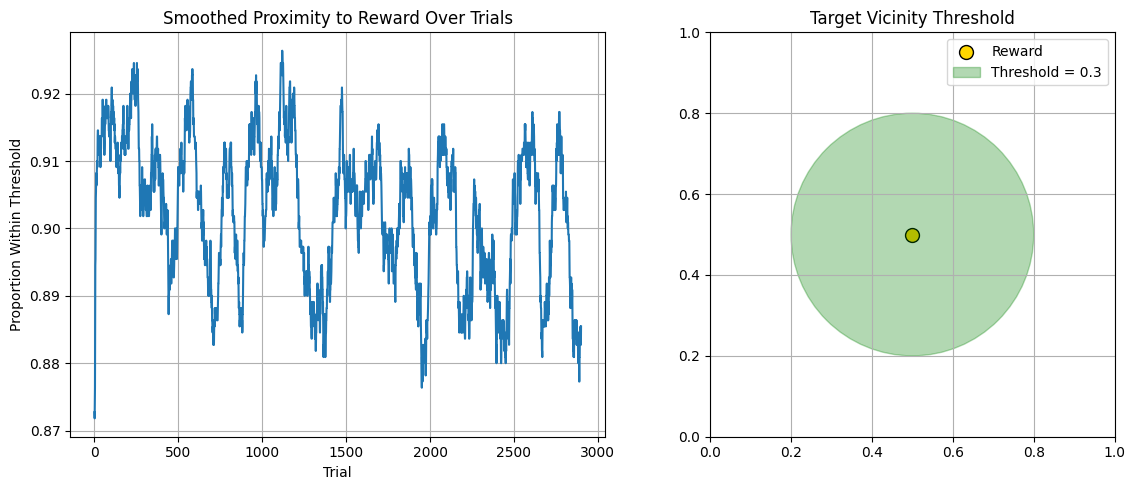

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def compute_proximity_ratios(trajectories, reward_pos, threshold=1.0):
    ratios = []
    for trial in trajectories:
        distances = np.linalg.norm(trial - np.array(reward_pos), axis=1)
        close_steps = np.sum(distances <= threshold)
        ratios.append(close_steps / len(trial))
    return ratios

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_proximity_ratio_and_threshold(proximity_ratios, reward_pos, threshold, grid_size=(1, 1), w=20):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(moving_average(proximity_ratios, w=w))
    axs[0].set_xlabel("Trial")
    axs[0].set_ylabel("Proportion Within Threshold")
    axs[0].set_title("Smoothed Proximity to Reward Over Trials")
    axs[0].grid(True)

    axs[1].set_title("Target Vicinity Threshold")
    axs[1].set_xlim(0, grid_size[0])
    axs[1].set_ylim(0, grid_size[1])
    axs[1].set_aspect('equal')
    axs[1].grid(True)

    axs[1].scatter(*reward_pos, color='gold', edgecolor='black', s=100, label='Reward')
    circle = Circle(reward_pos, threshold, color='green', alpha=0.3, label=f'Threshold = {threshold}')
    axs[1].add_patch(circle)

    axs[1].legend()
    plt.tight_layout()
    plt.show()

reward_pos = (0.5, 0.5)
threshold = 0.3
proximity_ratios = compute_proximity_ratios(results["trajectories"], reward_pos, threshold=threshold)
plot_proximity_ratio_and_threshold(proximity_ratios, reward_pos, threshold=threshold, grid_size=(1, 1), w=100)

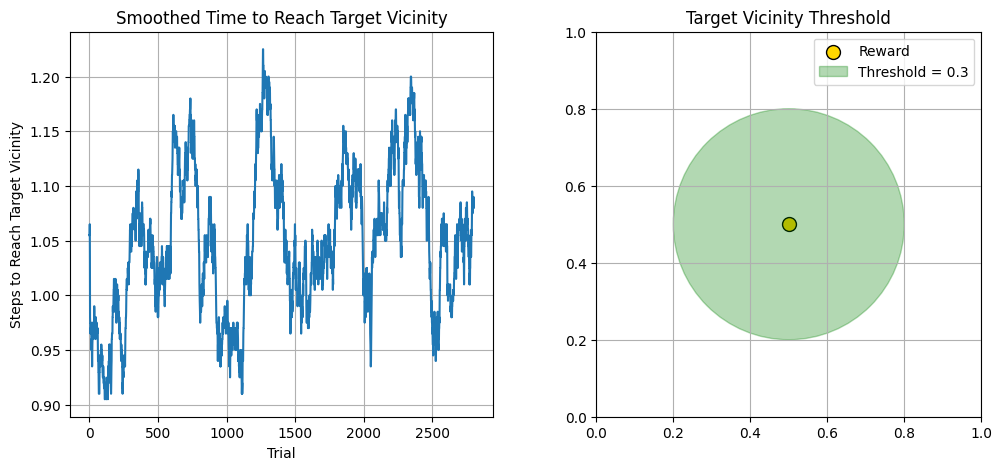

In [41]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def compute_time_to_vicinity(trajectories, reward_pos, threshold=0.35):
    times = []
    for trial in trajectories:
        distances = np.linalg.norm(trial - np.array(reward_pos), axis=1)
        below_thresh = np.where(distances <= threshold)[0]
        if len(below_thresh) > 0:
            times.append(below_thresh[0])
        else:
            times.append(len(trial))  # Never reached
    return times

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w)/w, mode='valid')

def plot_time_and_threshold(time_to_target, reward_pos, threshold, grid_size=(1, 1), w=100):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(moving_average(time_to_target, w=w))
    axs[0].set_xlabel("Trial")
    axs[0].set_ylabel("Steps to Reach Target Vicinity")
    axs[0].set_title("Smoothed Time to Reach Target Vicinity")
    axs[0].grid(True)

    # Plot 2: Grid with reward and threshold circle
    axs[1].set_title("Target Vicinity Threshold")
    axs[1].set_xlim(0, grid_size[0])
    axs[1].set_ylim(0, grid_size[1])
    axs[1].set_aspect('equal')
    axs[1].grid(True)

    # Plot reward
    axs[1].scatter(*reward_pos, color='gold', edgecolor='black', s=100, marker='o', label='Reward')

    # Plot threshold circle
    circle = Circle(reward_pos, radius=threshold, color='green', alpha=0.3, label=f'Threshold = {threshold}')
    axs[1].add_patch(circle)

    axs[1].legend()

threshold = 0.3
reward_pos = (0.5, 0.5)
time_to_target = compute_time_to_vicinity(results["trajectories"], reward_pos, threshold=threshold)
plot_time_and_threshold(time_to_target, reward_pos, threshold=threshold, grid_size=(1, 1), w=200)


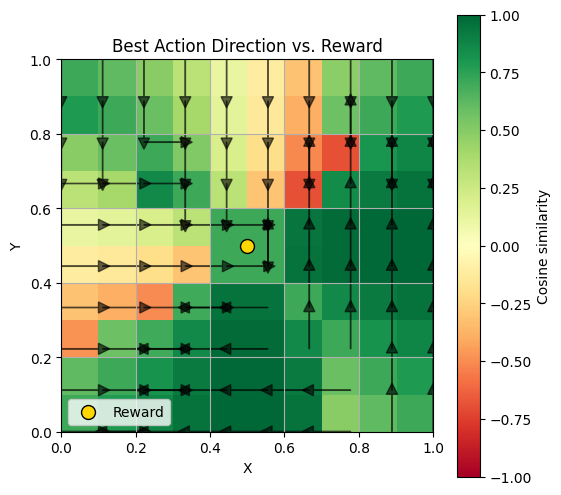

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def plot_weight_direction_heatmap_from_theta(
    theta, centers, actions,
    reward_pos,
    grid_shape,
    grid_size=(1,1),
    smooth_sigma=0.5,
    step_len=0.2
):
    """
    θ:       (num_cells*num_actions,1) or flat (num_cells*num_actions,)
    centers: list or array of shape (num_cells,2)
    actions: array of length num_actions (angles)
    """
    centers = np.asarray(centers)                         # (C,2)
    num_cells   = centers.shape[0]
    num_actions = len(actions)
    flat        = theta.flatten()
    # reshape so rows=actions, cols=cells
    B = flat.reshape(num_cells, num_actions).T            # (A,C)

    # build arrays
    place_centers = centers.reshape(*grid_shape, 2)       # (rows, cols, 2)
    angles        = np.asarray(actions)                   # (A,)
    directions    = np.stack([np.cos(angles), np.sin(angles)], axis=1)  # (A,2)

    # compute cosine-sim heatmap
    cosine_map = np.zeros(grid_shape)
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            idx = i * grid_shape[1] + j
            best_a = np.argmax(B[:, idx])
            dv     = directions[best_a]
            origin = place_centers[i, j]
            to_goal= np.array(reward_pos) - origin
            cosine_map[i,j] = (dv @ to_goal) / (np.linalg.norm(dv)*np.linalg.norm(to_goal)+1e-8)

    # smooth & plot
    sm = gaussian_filter(cosine_map, sigma=smooth_sigma)
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(sm, cmap='RdYlGn', origin='lower',
                   extent=[0,grid_size[0], 0,grid_size[1]],
                   vmin=-1, vmax=1)

    # overlay arrows
    for i in range(grid_shape[0]):
        for j in range(grid_shape[1]):
            idx = i * grid_shape[1] + j
            best_a = np.argmax(B[:, idx])
            dv     = directions[best_a]
            origin = place_centers[i, j]
            ax.arrow(origin[0], origin[1],
                     dv[0]*step_len, dv[1]*step_len,
                     head_width=0.03, head_length=0.03,
                     fc='black', ec='black', alpha=0.6)

    ax.scatter(*reward_pos, color='gold', edgecolor='black', s=100, label='Reward')
    ax.set_xlim(0, grid_size[0]); ax.set_ylim(0, grid_size[1])
    ax.set_aspect('equal')
    ax.set_title("Best Action Direction vs. Reward")
    ax.set_xlabel("X"); ax.set_ylabel("Y")
    ax.legend()
    fig.colorbar(im, ax=ax, label="Cosine similarity")
    plt.grid(True)
    plt.show()

plot_weight_direction_heatmap_from_theta(
    theta,                # your learned weights
    centers,              # list of (x,y)
    actions,              # action angles
    reward_pos=(0.5,0.5), # center of the grid
    grid_shape=(n_x,n_y),
    grid_size=(1,1),
    smooth_sigma=0.3,
    step_len=0.1
)

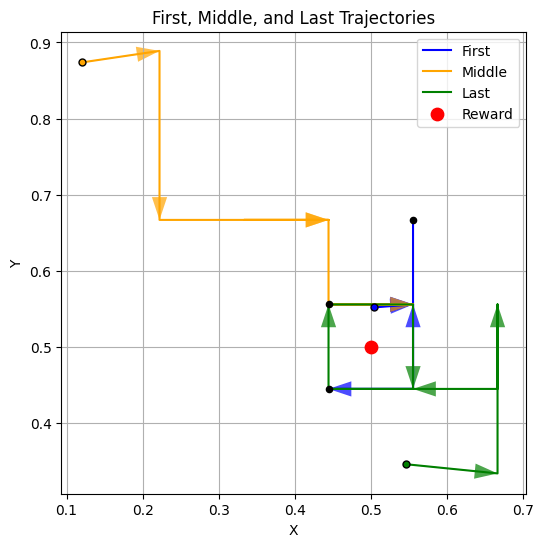

In [43]:
import matplotlib.pyplot as plt

def plot_key_trajectories(trajectories, reward_pos=None, show_arrows=True):
    """
    Plot first, middle, and last trajectories with direction arrows and color.

    Parameters:
    - trajectories: list of arrays of shape (T, 2)
    - reward_pos: optional (x, y) reward location
    - show_arrows: whether to add arrows along trajectory
    """
    idx_first = 0
    idx_middle = len(trajectories) // 2
    idx_last = len(trajectories) - 1

    selected = [
        (idx_first, 'blue', 'First'),
        (idx_middle, 'orange', 'Middle'),
        (idx_last, 'green', 'Last')
    ]

    plt.figure(figsize=(6, 6))

    for idx, color, label in selected:
        traj = np.array(trajectories[idx])
        plt.plot(traj[:, 0], traj[:, 1], color=color, label=label)

        # Start and end markers
        plt.scatter(*traj[0], color=color, s=25, edgecolor='black', zorder=3)
        plt.scatter(*traj[-1], color='black', s=20, zorder=3)

        if show_arrows and len(traj) > 1:
            skip = max(len(traj) // 5, 1)
            for i in range(0, len(traj)-1, skip):
                dx = traj[i+1, 0] - traj[i, 0]
                dy = traj[i+1, 1] - traj[i, 1]
                plt.arrow(traj[i, 0], traj[i, 1], dx, dy, 
                          shape='full', lw=0, length_includes_head=True,
                          head_width=0.02, color=color, alpha=0.7)

    if reward_pos is not None:
        plt.scatter(*reward_pos, color='red', s=80, label='Reward', zorder=4)

    plt.title("First, Middle, and Last Trajectories")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.axis("equal")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_key_trajectories(results["trajectories"], reward_pos=(0.5,0.5))


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from tqdm import tqdm

# Hyperparameter lists
n_vals       = [4, 5, 10]
delta_t_vals = [0.05, 0.1, 0.2]
beta_vals    = [0.01, 0.1, 0.3, 0.5]
temp_vals    = [0.01, 0.1, 0.5]
tau_I_vals   = [0.05, 0.1, 0.25, 0.5]
gamma_vals = [0.1, 1.0, 2.0]

actions = np.linspace(0, 2 * np.pi, 4, endpoint=False)
num_trials = 100
steps_per_trial = 10
snap_to_centers = False

grid_search_results = {}

for delta_t, beta, n, temp, tau_I, gamma in tqdm(
        list(product(delta_t_vals, beta_vals, n_vals, temp_vals, tau_I_vals, gamma_vals)),
        desc="Grid search"):

    # build place cells
    grid_x = np.linspace(0, 1, n)
    grid_y = np.linspace(0, 1, n)
    centers = [(x, y) for x in grid_x for y in grid_y]
    num_place_cells = len(centers)

    # init theta and env
    theta = np.random.uniform(0, 0.001, size=(num_place_cells * 4, 1))
    env = GridEnvironment(
        grid_size=(1,1),
        place_centers=centers,
        tau_I=tau_I,
        snap_to_centers=snap_to_centers,
        gamma=gamma
    )

    all_I_values     = []
    all_trajectories = []
    weight_history   = [theta.copy()]
    update_log       = []

    for trial in range(num_trials):
        env.reset()
        e_t = np.zeros_like(theta)
        I_values = []

        for t in range(steps_per_trial):
            x, y = env.get_position()
            s = place_cells(x, y, centers)
            a = select_action(s, theta, actions, temperature=temp)
            env.move(a)

            psi = outer_product_feature_vector(s, a)
            P_t = env.compute_I()
            e_t = eligibility_vector_update(e_t, psi, P_t, beta=beta, delta_t=delta_t)

            theta = weight_update(
                theta, P_t, e_t,
                update_log=update_log,
                trial_idx=trial, step_idx=t
            )
            weight_history.append(theta.copy())
            I_values.append(P_t)

        all_I_values.append(np.mean(I_values))
        all_trajectories.append(np.array(env.trajectory))

    # collect results
    grid_search_results[(delta_t, beta, n, temp, tau_I)] = {
        "avg_I_t": np.mean(all_I_values),
        "theta_final": theta,
        "weight_history": weight_history,
        "update_log": update_log,
        "trajectories": all_trajectories,
        "params": {"delta_t": delta_t, "beta": beta, "n": n, "temperature": temp, "tau_I": tau_I,
                   "gamma": gamma}
    }

# build summary DataFrame
summary_df = pd.DataFrame.from_records([
    {
      "delta_t": k[0],
      "beta": k[1],
      "n": k[2],
      "temperature": k[3],
      "tau_I": k[4],
      "gamma": k[5],
      "avg_I_t": v["avg_I_t"]
    }
    for k, v in grid_search_results.items()
])

# sort best → worst
summary_df_sorted = summary_df.sort_values(by="avg_I_t", ascending=False)

Grid search:   0%|          | 0/432 [00:00<?, ?it/s]C:\Users\nicho\AppData\Local\Temp\ipykernel_29152\3472578146.py:209: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  q = float(value_function_approximation(theta,psi))
C:\Users\nicho\AppData\Local\Temp\ipykernel_29152\3472578146.py:195: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  update_log.append((trial_idx, step_idx, idx, float(delta_theta[idx])))
Grid search: 100%|██████████| 432/432 [11:28<00:00,  1.59s/it]


     delta_t  beta   n  temperature  tau_I   avg_I_t
227     0.10  0.30  10         0.50   0.50  0.614357
11      0.05  0.01  10         0.50   0.50  0.604922
155     0.10  0.01  10         0.50   0.50  0.598035
171     0.10  0.01  40         0.01   0.50  0.591076
411     0.20  0.50  20         0.01   0.50  0.579397
..       ...   ...  ..          ...    ...       ...
180     0.10  0.10  10         0.01   0.05  0.004519
412     0.20  0.50  20         0.10   0.05  0.004449
340     0.20  0.10  20         0.10   0.05  0.004168
348     0.20  0.10  40         0.01   0.05  0.003716
192     0.10  0.10  20         0.01   0.05  0.003281

[432 rows x 6 columns]


In [585]:
summary_df_sorted

,delta_t,beta,n,temperature,tau_I,avg_I_t
227,0.10,0.30,10,0.50,0.50,0.614357
11,0.05,0.01,10,0.50,0.50,0.604922
155,0.10,0.01,10,0.50,0.50,0.598035
171,0.10,0.01,40,0.01,0.50,0.591076
411,0.20,0.50,20,0.01,0.50,0.579397
...,...,...,...,...,...,...
180,0.10,0.10,10,0.01,0.05,0.004519
412,0.20,0.50,20,0.10,0.05,0.004449
340,0.20,0.10,20,0.10,0.05,0.004168
348,0.20,0.10,40,0.01,0.05,0.003716
